# Find the Measured Velocities


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path
from tqdm import tqdm


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    if os.path.split(path)[-1] == "":
        raise ValueError("Recursive root not found")
    return recursive_root(os.path.split(path)[0], find=find)

try:
    ROOT = recursive_root(os.path.abspath("."))
except ValueError:
    print("Recursive root not found. Are you running this file from the correct directory?")
    sys.exit(1)
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [11]:
from src.walk_configs import walk_configs
from constants import experiment_path, default_experiment_path


In [12]:
# configs = list(walk_configs(experiment_path))
# default_configs = list(walk_configs(default_experiment_path))


In [13]:
# len(configs)


### Read the File


In [14]:
import pandas as pd


def get_summary_df(
    config, file_name: str, additional_params: dict = None, T: bool = False
) -> pd.DataFrame:
    if additional_params is None:
        additional_params = {}
    df = pd.read_parquet(Path(config.Metadata.cwd) / file_name)
    if T:
        df = df.T
    for key, value in additional_params.items():
        df[key] = value
    return df


def get_fuel(config, **aditional_params) -> float:
    # pandas
    df = pd.read_csv(
        config.Blocks.FuelTotalConfig.output_path, header=None, names=["time", "fuel"]
    )
    for param, value in aditional_params.items():
        df[param] = value
    return df


In [15]:
# import contextlib

# west_thru_dfs = []
# east_thru_dfs = []
# calibration_dfs = []
# headway_dfs = []
# fuel_dfs = []
# for config in tqdm(configs):
#     additional_params = {
#         "num": config.Metadata.run_id,
#         "carFollowingModel": config.Blocks.CFTableConfig.additional_params.carFollowModel,
#         "seed": config.Blocks.SeedConfig.seed,
#         "cf-table": config.Pipeline.pipeline[0].producers[0].config.val,
#     }
#     with contextlib.suppress(FileNotFoundError):
#         df = get_summary_df(
#             config,
#             file_name="Radar137_East_thru_lowess_summary_df.parquet",
#             additional_params=additional_params,
#         )
#         df["method"] = "lowess"
#         df.rename(columns={"start_time": "start", "end_time": "end"}, inplace=True)

#         pwlf_df = get_summary_df(
#             config,
#             file_name="Radar137_East_thru_pwlf_summary_df.parquet",
#             additional_params=additional_params,
#         )
#         pwlf_df["method"] = "pwlf"

#         df = pd.concat([df, pwlf_df])
#         east_thru_dfs.append(df)

#         df = pd.read_parquet(Path(config.Metadata.cwd) / "calibration_df.parquet")
#         df = df.set_index(
#             "box",
#         ).T
#         for key, value in additional_params.items():
#             df[key] = value

#         calibration_dfs.append(df)

#         # get the headway data
#         headway_df = get_summary_df(
#             config,
#             file_name="Radar137_East_thru_headway_df.parquet",
#             additional_params=additional_params,
#         )

#         headway_dfs.append(headway_df)

#         # get the fuel data
#         with open(config.Blocks.FuelTotalConfig.output_path, "r") as f:
#             # split the file into lines
#             energy, cars = f.read().split(",")
#             additional_params["energy"] = float(energy)
#             additional_params["cars"] = int(cars)

#         fuel_df = pd.DataFrame(additional_params, index=[0])
#         fuel_dfs.append(fuel_df)


# east_thru_df = pd.concat(east_thru_dfs)
# calibration_df = pd.concat(calibration_dfs)
# fuel_df = pd.concat(fuel_dfs)
# headway_df = pd.concat(headway_dfs)


In [16]:
# save the data
# east_thru_df.to_parquet(experiment_path / "east_thru_df.parquet")
# calibration_df.to_parquet(experiment_path / "calibration_df.parquet")
# fuel_df.to_parquet(experiment_path / "fuel_df.parquet")
# headway_df.to_parquet(experiment_path / "headway_df.parquet")
headway_df = pd.read_parquet(experiment_path / "headway_df.parquet")
fuel_df = pd.read_parquet(experiment_path / "fuel_df.parquet")
calibration_df = pd.read_parquet(experiment_path / "calibration_df.parquet")
east_thru_df = pd.read_parquet(experiment_path / "east_thru_df.parquet")

In [241]:
calibration_df.groupby(["carFollowingModel", 'cf-table']).mean()

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_40393/2642228736.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  calibration_df.groupby(["carFollowingModel", 'cf-table']).mean()


box                                  West thru  East thru  West right  \
carFollowingModel cf-table                                              
EIDM              corr_lowess         0.910526   0.792982    0.946491   
                  corr_pwlf_product   0.906140   0.826316    0.945614   
                  uncor_pwlf          0.875439   0.575439    0.922807   
IDM               corr_lowess         0.897368   0.803509    0.945614   
                  corr_pwlf_product   0.901754   0.850000    0.942982   
                  uncor_pwlf          0.877193   0.614035    0.921930   
Krauss            corr_lowess         0.722807   0.420175    0.741228   
                  corr_pwlf_product   0.742982   0.401754    0.720175   
                  uncor_pwlf          0.733333   0.414035    0.800877   

box                                  South left  South right        seed  
carFollowingModel cf-table                                                
EIDM              corr_lowess          0.948246     0.960526  400.933333  
                  corr_pwlf_product    0.951754     0.960526  400.933333  
                  uncor_pwlf           0.948246     0.959649  400.933333  
IDM               corr_lowess          0.948246     0.961404  400.933333  
                  corr_pwlf_product    0.950000     0.960526  400.933333  
                  uncor_pwlf           0.950877     0.959649  400.933333  
Krauss            corr_lowess          0.947368     0.960526  400.933333  
                  corr_pwlf_product    0.945614     0.961404  400.933333  
                  uncor_pwlf           0.948246     0.960526  400.933333

In [17]:
default_headway_df = pd.read_parquet(default_experiment_path / "headway_df.parquet")
default_fuel_df = pd.read_parquet(default_experiment_path / "fuel_df.parquet")
default_calibration_df = pd.read_parquet(default_experiment_path / "calibration_df.parquet")
default_east_thru_df = pd.read_parquet(default_experiment_path / "east_thru_df.parquet")

In [242]:
default_calibration_df.groupby(["carFollowingModel",]).mean()

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_40393/3302920355.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  default_calibration_df.groupby(["carFollowingModel",]).mean()


box,West thru,East thru,West right,South left,South right,seed
carFollowingModel,,,,,,
EIDM - default,0.945614,0.944737,0.958772,0.950000,0.959649,400.933333
IDM - default,0.946491,0.950000,0.959649,0.949123,0.960526,401.800000
Krauss - default,0.946491,0.949123,0.958772,0.950877,0.960526,400.933333
W99 - default,0.945614,0.949123,0.958772,0.947368,0.960526,400.933333


In [18]:
# save the headway dfs locally

headway_df.to_parquet("headway_df.parquet")
default_headway_df.to_parquet("default_headway_df.parquet")

In [19]:
default_headway_df["cf-table"] = "default"
default_fuel_df["cf-table"] = "default"
default_calibration_df["cf-table"] = "default"
default_east_thru_df["cf-table"] = "default"

default_headway_df["carFollowingModel"] = default_headway_df["carFollowingModel"] + " - default"
default_fuel_df["carFollowingModel"] = default_fuel_df["carFollowingModel"] + " - default"
default_calibration_df["carFollowingModel"] = default_calibration_df["carFollowingModel"] + " - default"
default_east_thru_df["carFollowingModel"] = default_east_thru_df["carFollowingModel"] + " - default"

In [20]:
default_headway_df['vehicle_run'] = default_headway_df['num'].astype(str) + '~' + default_headway_df['veh'].astype(str) + '~' + default_headway_df['cf-table'].astype(str)
default_east_thru_df['vehicle_run'] = default_east_thru_df['num'].astype(str) + '~' + default_east_thru_df['vehicle_id'].astype(str) + '~' + default_east_thru_df['cf-table'].astype(str)

# create a vehicle ~ run id column
headway_df['vehicle_run'] = headway_df['num'].astype(str) + '~' + headway_df['veh'].astype(str) + '~' + headway_df['cf-table'].astype(str)
east_thru_df['vehicle_run'] = east_thru_df['num'].astype(str) + '~' + east_thru_df['vehicle_id'].astype(str) + '~' + east_thru_df['cf-table'].astype(str)

In [22]:
headway_df = pd.concat([headway_df, default_headway_df])
fuel_df = pd.concat([fuel_df, default_fuel_df])
east_thru_df = pd.concat([east_thru_df, default_east_thru_df])

In [32]:
east_thru_df['cf-table'].unique()

array(['corr_lowess', 'corr_pwlf_product', 'uncor_pwlf', 'default'],
      dtype=object)

### Get the Fuel Consumption


In [23]:
SUMO_GASOLINE_GRAM_TO_JOULE: float = 43.4e-3
GRAM_TO_CM3: float = 0.7489
CM3_TO_LITER: float = 0.001


fuel_df["volume_L"] = (
    fuel_df["energy"] / (SUMO_GASOLINE_GRAM_TO_JOULE) * GRAM_TO_CM3 * CM3_TO_LITER
)
fuel_df["volume_L_per_vehicle"] = fuel_df["volume_L"] / fuel_df["cars"]


## Read the RW Data


In [24]:
# pwlf_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/pwlf_method.parquet"))
# pwlf_rw_df["method"] = "pwlf"
# pwlf_rw_df["carFollowingModel"] = "Real World"
# pwlf_rw_df["num"] = 0
# pwlf_rw_df["cf-table"] = "Real World"

headway_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/headway.parquet"))
headway_rw_df["carFollowingModel"] = "Real World"
headway_rw_df["num"] = 0
headway_rw_df["cf-table"] = "Real World"


## Process the Data


In [25]:
import numpy as np


def label_types(
    df,
    cruise_thresh_accel: float,
):
    df["type"] = np.where(df["accel"] > cruise_thresh_accel, "accel", "")
    df["type"] = np.where(df["accel"] < -cruise_thresh_accel, "decel", df["type"])
    df["type"] = np.where(
        df["accel"].abs() <= cruise_thresh_accel, "cruise", df["type"]
    )
    return df


def get_vehicle_averages(
    df: pd.DataFrame, groupby_cols=None, descript_cols=None, weight_average_col="accel"
) -> pd.DataFrame:
    if groupby_cols is None:
        groupby_cols = ["num", "method", "vehicle_id"]
    if descript_cols is None:
        descript_cols = [
            "carFollowingModel",
            "cf-table",
            "seed",
        ]
    grouper = df.groupby(groupby_cols)
    grouped_df = grouper[descript_cols].first()
    grouped_df[weight_average_col] = grouper.apply(
        lambda x: np.average(x[weight_average_col], weights=x["time_diff"])
    )
    return grouped_df.reset_index()


## Plot the Histograms


In [26]:
table = "corr_pwlf_product"
# read in the rw data
rw_df = pd.read_csv(
    ROOT / Path(f"data/2023-01-13/processed/{table}.csv"),
)


### Make SUMO Table Similar to RW


In [27]:
import polars as pl

# create an product sample
minium_time_in_state = 1
r2 = 0.95


def get_product_sample(
    df,
    headway_df
):
    # get the product sample
    pwlf_data_keep = df.loc[
        (df.time_diff > minium_time_in_state)
        & (df.r2 > r2)
        & df.type.isin(["accel", "decel"])
    ].copy()
    
    # keep vehicles that have both accel and decel
    pwlf_data_keep = pwlf_data_keep.groupby("vehicle_run").filter(
        lambda x: x.type.nunique() == 2
    )

    res = []
    for v_id, v_df in pwlf_data_keep.groupby("vehicle_run"):
        accels = v_df[v_df.type == "accel"].accel.values
        decels = v_df[v_df.type == "decel"].accel.values
        for accel in accels:
            res.extend(
                {"vehicle_run": v_id, "num": v_id.split("~")[0], "accel": accel, "decel": decel} for decel in decels
            )
    # create a dataframe
    pwlf_df_product = pd.DataFrame(res)

    # merge in the headway data
    pwlf_df_product = pwlf_df_product.merge(
        headway_df[["num", "veh", "mean", "vehicle_run"]].rename(
            columns={"veh": "vehicle_id", "mean": "headway"}
        ), on=["vehicle_run"]
    )

    return pwlf_df_product



def get_average_speed(
    df,
    headway_df,
):
    
    sumo_df_pl = pl.DataFrame(df)
    keep_ids = sumo_df_pl.groupby(
        "vehicle_run"
    ).agg([
        pl.col('accel').abs().max().alias('max_accel'),

    ]).filter(
        (pl.col('max_accel') < 1)
        & (~pl.col('vehicle_run').is_in(headway_df['vehicle_run'].unique().tolist()))
    ).select(
        pl.col('vehicle_run')
    ).to_pandas().values.flatten().tolist()

    return sumo_df_pl.filter(
        pl.col('vehicle_run').is_in(keep_ids)
        & pl.col('type').is_in(['cruise'])
    ).to_pandas()

In [59]:
import seaborn as sns
import numpy as np


def create_ecdf(
    plot_df,
    ax,
    color_map,
    x_lims,
    plot_col,
    xlabel,
    loop_models,
    ylabel=None,
    show_legend=False,
):
    labels = []
    for i, model in enumerate(loop_models):
        labels += [model]
        # add the mean
        model_df = plot_df[plot_df["carFollowingModel"] == model].copy()

        sorted_x = np.sort(model_df[plot_col].values)
        yvals = np.linspace(0, 1, model_df[plot_col].values.shape[0])

        if model != "Real World":
            # only keep 1/10 of the data
            sorted_x = sorted_x[::100]
            yvals = yvals[::100]

        sns.lineplot(
            # don't use 
            x=sorted_x,
            y=yvals,
            ax=ax,
            color=color_map[model],
            alpha=1,
            linewidth=3,
            legend=bool(show_legend),
            label=model,
        )

        # # add a vertical line at the median
        # median = np.median(model_df[plot_col].values)
        # ax.axvline(median, color=color_map[model], linestyle="--", alpha=1, linewidth=1)

        if model == "Real World":
            continue

        for _, seed_df in model_df.groupby("num"):
                
            sorted_x = np.sort(seed_df[plot_col].values)
            yvals = np.linspace(0, 1, seed_df[plot_col].values.shape[0])

            # only keep 1/10 of the data
            sorted_x = sorted_x[::10]
            yvals = yvals[::10]

            sns.lineplot(
                x=sorted_x,
                y=yvals,
                ax=ax,
                color=color_map[model],
                alpha=0.2,
                linewidth=1,
                legend=False,
            )

    # # remove the legend
    # if not show_legend:
    #     ax.legend_.remove()
    ax.set_xlabel(xlabel)
    # set the x and y axis limits
    ax.set_xlim(*x_lims)


In [40]:
east_thru_df = east_thru_df.loc[~east_thru_df['carFollowingModel'].str.contains('W99')].copy()

In [53]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})
palette = sns.color_palette(
    "Paired",
    12,
)

# swap the order every 2 colors
for i in range(0, len(palette), 2):
    palette[i], palette[i + 1] = palette[i + 1], palette[i]

# colors = [palette[i] for i in range(0, len(palette))]


In [ ]:

# # do the pwlf method
table = "corr_pwlf_product"
# read in the rw data
rw_df = pd.read_csv(
    ROOT / Path(f"data/2023-01-13/processed/{table}.csv"),
)
rw_df['carFollowingModel'] = 'Real World'
rw_df = rw_df.rename(columns={'tau': 'headway'})

# get the pwlf data
sumo_df_raw = east_thru_df[
    (east_thru_df["cf-table"].isin([table, 'default']))
].copy()
sumo_df_raw = label_types(sumo_df_raw, cruise_thresh_accel=0.1)
cf_models = east_thru_df["carFollowingModel"].unique().tolist()
cf_models.sort()
cf_models.append("Real World")

# get the product sample
sumo_df = get_product_sample(
    sumo_df_raw.copy(),
    headway_df
)

# merge in the carFollowingModel
sumo_df = sumo_df.merge(
    east_thru_df[["num", "vehicle_run", "carFollowingModel"]].drop_duplicates(),
    on=["vehicle_run"],
)

colors = {**dict(zip(cf_models, palette)), 'Real World': 'black'}


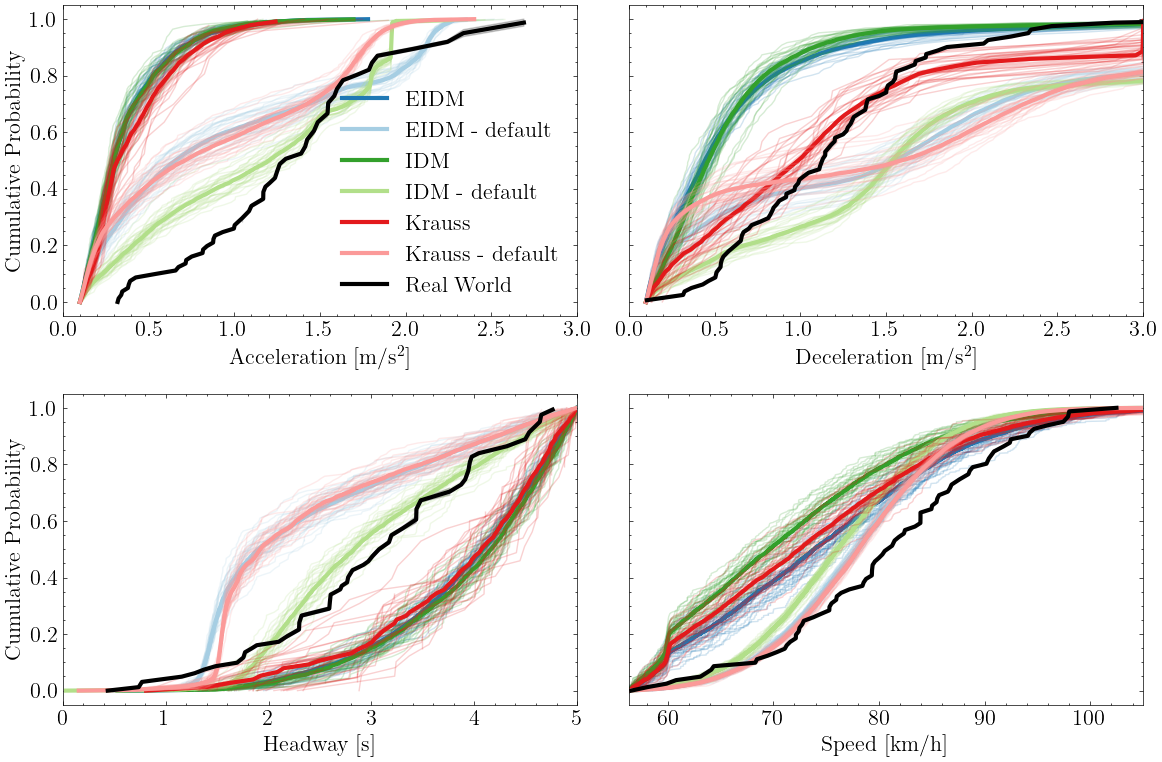

In [66]:
fig, ax = plt.subplots(
    figsize=(12, 8), nrows=2, ncols=2, sharey=True, tight_layout=True
)

# add y-axis labels to the left
ax[0, 0].set_ylabel("Cumulative Probability")
ax[1, 0].set_ylabel("Cumulative Probability")

accel_averages = pd.concat([
    sumo_df,
    rw_df
])
create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    loop_models=cf_models,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
)

for t in ax[0, 0].legend_.texts:
    t.set_fontsize(16)

# plot the deceleration
accel_averages['decel'] = accel_averages['decel'].abs()
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    loop_models=cf_models,
    x_lims=(0, 3),
    plot_col="decel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
)

# plot the headway
create_ecdf(
    accel_averages,
    ax[1, 0],
    color_map=colors,
    loop_models=cf_models,
    x_lims=(0, 5),
    plot_col="headway",
    xlabel="Headway [s]",
    show_legend=False,
)

# only vehicles faster than
sumo_avg = get_average_speed(sumo_df_raw, headway_df)[['speed', 'num', 'vehicle_run', 'carFollowingModel']]
rw_avg = rw_df[['speedFactor']].copy()
rw_avg['speedFactor'] = rw_avg.speedFactor * 22.35
rw_avg = rw_avg.rename(columns={'speedFactor': 'speed'})
rw_avg['carFollowingModel'] = 'Real World'


# convert both to kp/h
sumo_avg['speed'] = sumo_avg['speed'] * 3.6
rw_avg['speed'] = rw_avg['speed'] * 3.6

# limit both to > 35 km/h
sumo_avg = sumo_avg[(sumo_avg['speed'] > (35 * 1.60934))]

cruise_averages = pd.concat([
    sumo_avg,
    rw_avg
])

create_ecdf(
    cruise_averages,
    ax[1, 1],
    color_map=colors,
    loop_models=cf_models,
    x_lims=(35 * 1.60934, 105),
    plot_col="speed",
    xlabel="Speed [km/h]",
    show_legend=False,
)


In [169]:
speed_avg = cruise_averages.groupby('carFollowingModel').describe(
    percentiles=[0.1, 0.5, 0.9]
)
accel_avg = accel_averages.groupby('carFollowingModel')[['accel', 'decel', 'headway']].describe(
    percentiles=[0.1, 0.5, 0.9]
)
# join the two tables
avg_df = speed_avg.join(accel_avg)

fuel_df_summary = fuel_df.groupby('carFollowingModel')[['volume_L_per_vehicle']].describe(
    percentiles=[0.1, 0.5, 0.9]
)
# drop W99 - default
fuel_df_summary = fuel_df_summary.drop('W99 - default', )
avg_df = avg_df.join(fuel_df_summary)

# drop the stats we don't want
avg_df = avg_df.drop(
    columns=[
        'count',
        'min',
        'max',
        'std',
    ],
    level=1,
)
avg_df.reset_index(inplace=True)
avg_df['model'] = avg_df['carFollowingModel'].str.split('-').str[0]
avg_df['mode'] = avg_df['carFollowingModel'].str.split('-').str[1].fillna("sampled")

# create a multi-index from the model and mode
avg_df.set_index(['model', 'mode'], inplace=True, drop=True)
avg_df.sort_index(inplace=True)

avg_df.drop(
    columns=['carFollowingModel'],
    inplace=True,
)
# rename the 10% to $P_{10}$ and 90% to $P_{90}$ etc.
avg_df.rename(
    columns={
        '10%': '$P_{10\%}$',
        '50%': '$P_{50\%}$',
        '90%': '$P_{90\%}$',
    },
    level=1,
    inplace=True,
)


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_40393/3317871722.py:35: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  avg_df.drop(


In [156]:
avg_df

speed                                      accel  \
                          mean $P_{10\%}$ $P_{50\%}$ $P_{90\%}$      mean   
model      mode                                                             
EIDM       sampled   74.761345  59.778924  73.872000  90.756000  0.369391   
EIDM        default  77.833283  67.608000  77.868000  88.020000  0.942017   
IDM        sampled   71.229191  59.184000  69.644000  86.256000  0.369894   
IDM         default  76.267492  66.132000  76.068000  86.508000  1.117184   
Krauss     sampled   73.572312  59.750981  72.474003  89.336559  0.414601   
Krauss      default  78.057100  67.860000  78.082768  88.085212  0.874403   
Real World sampled   80.600680  68.306796  80.892343  93.930037  1.320784   

                                                         decel             \
                    $P_{10\%}$ $P_{50\%}$ $P_{90\%}$      mean $P_{10\%}$   
model      mode                                                             
EIDM       sampled    0.138364   0.297894   0.694816  0.619763   0.141917   
EIDM        default   0.150252   0.656309   2.115526  1.754518   0.166363   
IDM        sampled    0.141566   0.296119   0.709299  0.618670   0.178644   
IDM         default   0.231878   1.200087   1.914778  1.770905   0.324564   
Krauss     sampled    0.159386   0.319322   0.791273  1.160959   0.202696   
Krauss      default   0.143140   0.712500   1.764071  1.578407   0.140319   
Real World sampled    0.551501   1.283204   2.046407  1.170402   0.511644   

                                            headway                        \
                    $P_{50\%}$ $P_{90\%}$      mean $P_{10\%}$ $P_{50\%}$   
model      mode                                                             
EIDM       sampled    0.444253   1.242318  3.901968   2.678308   4.082523   
EIDM        default   1.556070   4.402692  2.383162   1.383508   1.899803   
IDM        sampled    0.464350   1.078794  3.947482   2.700126   4.162468   
IDM         default   1.536041   3.731679  3.012014   1.872035   2.832128   
Krauss     sampled    0.988235   2.996947  3.835100   2.435472   4.071394   
Krauss      default   1.586374   3.697474  2.402261   1.511221   1.919212   
Real World sampled    1.127813   1.850169  3.033912   1.700676   3.074557   

                               volume_L_per_vehicle                        \
                    $P_{90\%}$                 mean $P_{10\%}$ $P_{50\%}$   
model      mode                                                             
EIDM       sampled    4.841256             0.857042   0.792872   0.857734   
EIDM        default   4.220750             0.553425   0.548047   0.554003   
IDM        sampled    4.862599             0.805246   0.715887   0.821786   
IDM         default   4.497045             0.522650   0.518977   0.522784   
Krauss     sampled    4.793447             1.298090   1.253169   1.301847   
Krauss      default   4.218717             0.597267   0.592988   0.598298   
Real World sampled    4.530210                  NaN        NaN        NaN   

                                
                    $P_{90\%}$  
model      mode                 
EIDM       sampled    0.926984  
EIDM        default   0.558143  
IDM        sampled    0.875908  
IDM         default   0.526080  
Krauss     sampled    1.350194  
Krauss      default   0.601181  
Real World sampled         NaN

In [157]:
avg_df.T.style.format("{:.2f}").to_latex(
    "avg_stats.tex",
    multirow_align="c",
)
# turn the index into a multiindex



In [118]:
avg_df.T.style.format("{:.2f}")

In [62]:
# make the text on the ax[0, 0] legend smaller
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles, labels, fontsize=12)



### Uncorrelated Samples

In [173]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})

palette = sns.color_palette(
    "Paired",
    12,
)
# swap the order every 2 colors
for i in range(0, len(palette), 2):
    palette[i], palette[i + 1] = palette[i + 1], palette[i]

# # do the pwlf method
table = "uncor_pwlf"
# read in the rw data
rw_df = pd.read_csv(
    ROOT / Path(f"data/2023-01-13/processed/{table}.csv"),
)
rw_df['carFollowingModel'] = 'Real World'
rw_df = rw_df.rename(columns={'tau': 'headway'})

# get the pwlf data
sumo_df_raw = east_thru_df[
    (east_thru_df["cf-table"].isin([table, 'default']))
].copy()
sumo_df_raw = label_types(sumo_df_raw, cruise_thresh_accel=0.1)

cf_models = east_thru_df["carFollowingModel"].unique().tolist()
cf_models.sort()
# add in the real world
cf_models.append("Real World")

colors = {
    **dict(zip(cf_models, palette)),
    "Real World": "black",
}


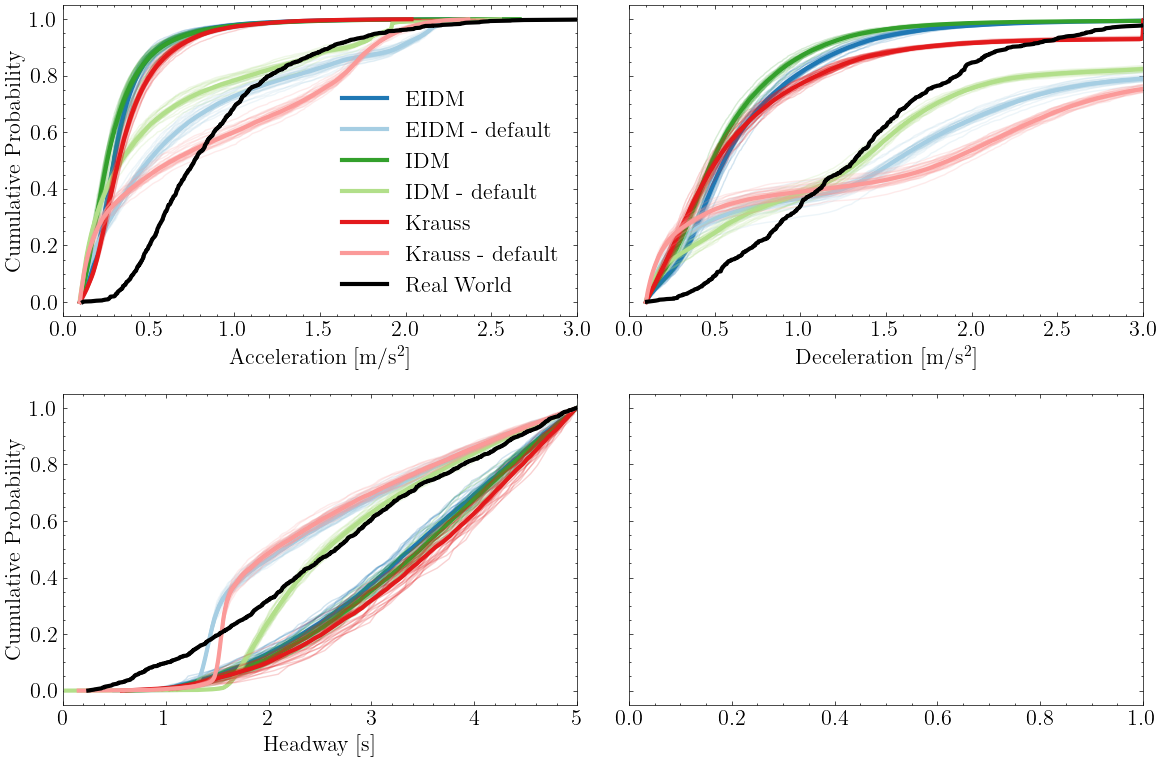

In [174]:
# create an product sample
minium_time_in_state = 1
r2 = 0.95

fig, ax = plt.subplots(
    figsize=(12, 8), nrows=2, ncols=2, sharey=True, tight_layout=True
)

# add y-axis labels to the left
ax[0, 0].set_ylabel("Cumulative Probability")
ax[1, 0].set_ylabel("Cumulative Probability")

sumo_accels = sumo_df_raw.loc[
    (sumo_df_raw.type == 'accel')
    & (sumo_df_raw['time_diff'] > minium_time_in_state)
    & (sumo_df_raw['r2'] > r2),
    ['accel', 'num', 'vehicle_run', 'carFollowingModel']
]

accel_averages = pd.concat([
    sumo_accels,
    rw_df
])
# save the averages
acceleration_averages = accel_averages.copy()

create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
    loop_models=cf_models,
)

# plot the deceleration
sumo_accels = sumo_df_raw.loc[
    (sumo_df_raw.type == 'decel')
    & (sumo_df_raw['time_diff'] > minium_time_in_state)
    & (sumo_df_raw['r2'] > r2),
    ['accel', 'num', 'vehicle_run', 'carFollowingModel']
]

sumo_accels['decel'] = sumo_accels['accel'].abs()
accel_averages = pd.concat([
    sumo_accels,
    rw_df
])
decleration_averages = accel_averages.copy()
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="decel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
    loop_models=cf_models
)

headways = headway_df[['num', 'vehicle_run', 'mean']].loc[
    headway_df.vehicle_run.isin(sumo_df_raw.vehicle_run.unique())
].rename(columns={'mean': 'headway'})
headways = headways.merge(
    sumo_df_raw[['vehicle_run', 'carFollowingModel']].groupby('vehicle_run').first().reset_index(),
    on=['vehicle_run'],
    how='left'
)
rw_headways = rw_df[['headway', 'carFollowingModel']].copy()
headway_plot_df = pd.concat(
    [
        headways,
        rw_headways

    ]
)

# plot the headway
create_ecdf(
    headway_plot_df,
    ax[1, 0],
    color_map=colors,
    x_lims=(0, 5),
    plot_col="headway",
    xlabel="Headway [s]",
    show_legend=False,
    loop_models=cf_models
)

# only vehicles faster than
sumo_avg = get_average_speed(sumo_df_raw, headway_df)[['speed', 'num', 'vehicle_run', 'carFollowingModel']]
rw_avg = rw_df[['speedFactor']].copy()
rw_avg['speedFactor'] = rw_avg.speedFactor * 22.35
rw_avg = rw_avg.rename(columns={'speedFactor': 'speed'})
rw_avg['carFollowingModel'] = 'Real World'


# convert both to kp/h
sumo_avg['speed'] = sumo_avg['speed'] * 3.6
rw_avg['speed'] = rw_avg['speed'] * 3.6

# limit both to > 35 km/h
sumo_avg = sumo_avg[(sumo_avg['speed'] > (35 * 1.60934))]

cruise_averages = pd.concat([
    sumo_avg,
    rw_avg
])

# create_ecdf(
#     cruise_averages,
#     ax[1, 1],
#     color_map=colors,
#     x_lims=(35 * 1.60934, 105),
#     plot_col="speed",
#     xlabel="Speed [km/h]",
#     show_legend=False,
#     loop_models=cf_models
# )


In [180]:
speed_avg = cruise_averages.groupby('carFollowingModel').describe(
    percentiles=[0.1, 0.5, 0.9]
)
accel_avg = acceleration_averages.groupby('carFollowingModel')[['accel']].describe(
    percentiles=[0.1, 0.5, 0.9]
)
decel_avg = decleration_averages.groupby('carFollowingModel')[['decel']].describe(
    percentiles=[0.1, 0.5, 0.9]
)
headway_avg = headway_plot_df.groupby('carFollowingModel')[['headway']].describe(
    percentiles=[0.1, 0.5, 0.9]
)

# join everything together
avg_df = speed_avg.join(accel_avg)
avg_df = avg_df.join(decel_avg)
avg_df = avg_df.join(headway_avg)

fuel_df_summary = fuel_df.groupby('carFollowingModel')[['volume_L_per_vehicle']].describe(
    percentiles=[0.1, 0.5, 0.9]
)
# drop W99 - default
fuel_df_summary = fuel_df_summary.drop('W99 - default', )
avg_df = avg_df.join(fuel_df_summary)

# # drop the stats we don't want
avg_df = avg_df.drop(
    columns=[
        'count',
        'min',
        'max',
        'std',
    ],
    level=1,
)
avg_df.reset_index(inplace=True)
avg_df['model'] = avg_df['carFollowingModel'].str.split('-').str[0]
avg_df['mode'] = avg_df['carFollowingModel'].str.split('-').str[1].fillna("sampled")

# create a multi-index from the model and mode
avg_df.set_index(['model', 'mode'], inplace=True, drop=True)
avg_df.sort_index(inplace=True)

avg_df.drop(
    columns=['carFollowingModel'],
    inplace=True,
)
# rename the 10% to $P_{10}$ and 90% to $P_{90}$ etc.
avg_df.rename(
    columns={
        '10%': '$P_{10\%}$',
        '50%': '$P_{50\%}$',
        '90%': '$P_{90\%}$',
    },
    level=1,
    inplace=True,
)


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_40393/3255314642.py:44: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  avg_df.drop(


In [182]:
avg_df.T.style.format("{:.2f}").to_latex(
    "avg_stats_independent.tex",
    multirow_align="c",
)

In [184]:
pwlf_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/pwlf_method.parquet"))
pwlf_rw_df["method"] = "pwlf"
pwlf_rw_df['carFollowingModel'] = 'Real World'
pwlf_rw_df['num'] = 0

headway_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/headway.parquet"))
headway_rw_df['carFollowingModel'] = 'Real World'
headway_rw_df['num'] = 0

In [208]:
rw_keep_vehicle_ids = headway_rw_df.loc[headway_rw_df["mean"] < 5, "veh"].unique()
sumo_keep_vehicle_ids = headway_df.loc[headway_df["mean"] < 5, "vehicle_run"].unique().tolist()

In [209]:
max_accel = pwlf_rw_df.loc[
    pwlf_rw_df.vehicle_id.isin(rw_keep_vehicle_ids)
].groupby("vehicle_id").accel.apply(lambda x: np.abs(x).max())
rw_keep_vehicle_ids = max_accel.loc[max_accel < 1].index.values

In [217]:
# do speed
# # do the pwlf method
table = "uncor_pwlf"

# get the pwlf data
sumo_df_raw = east_thru_df[
    (east_thru_df["cf-table"].isin([table, 'default']))
].copy()
sumo_df_raw = label_types(sumo_df_raw, cruise_thresh_accel=0.1)

# get the headway data
rw_df = label_types(pwlf_rw_df, cruise_thresh_accel=0.1)


In [236]:
sumo_keep_vehicle_ids = pl.DataFrame(east_thru_df).filter(
    pl.col('vehicle_run').is_in(sumo_keep_vehicle_ids)
).groupby(
    'vehicle_run'
).agg(
    pl.col('accel').abs().max().alias('max_accel'),
).filter(
    pl.col('max_accel') < 1
).to_pandas().vehicle_run.unique().tolist()


In [237]:

cruise_sumo_df = sumo_df_raw.loc[
    (sumo_df_raw["type"] == "cruise")
    & (sumo_df_raw["time_diff"] > 0.1)
    & (sumo_df_raw["vehicle_run"].isin(sumo_keep_vehicle_ids))
].copy()

cruise_rw_df = rw_df.loc[
    (rw_df["type"] == "cruise")
    & (rw_df["time_diff"] > 0.1)
    & (rw_df["vehicle_id"].isin(rw_keep_vehicle_ids))
].copy()


# concat the data
cruise_df = pd.concat([cruise_sumo_df, cruise_rw_df])


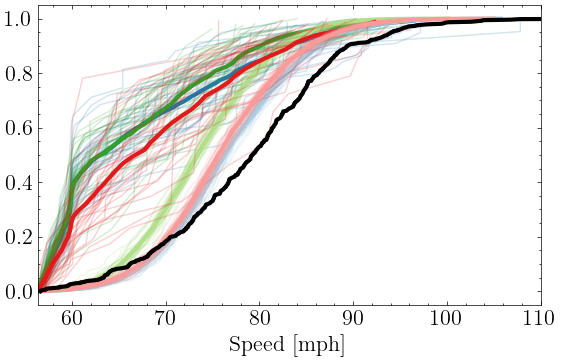

In [238]:
fig, ax = plt.subplots(
    figsize=(6, 4), nrows=1, ncols=1, sharey=True, tight_layout=True
)

cruise_df['speed'] *= 3.6
cruise_averages = cruise_df.loc[cruise_df['speed'] > (35 * 1.60934)]

# only vehicles faster than 

create_ecdf(
    cruise_averages,
    ax,
    color_map=colors,
    x_lims=(35 * 1.60934, 110),
    plot_col="speed",
    xlabel="Speed [mph]",
    show_legend=False,
    loop_models=cf_models
)


In [171]:
# import matplotlib.pyplot as plt
# import scienceplots
# import seaborn as sns

# plt.style.use("science")
# # make the text bigger
# plt.rcParams.update({"font.size": 16})
# palette = sns.color_palette(
#     "Paired",
#     8,
# )
# colors = [palette[i] for i in range(0, len(palette), 2)]


# # # do the pwlf method
# sumo_df = east_thru_df[
#     (east_thru_df["method"] == "lowess") & (east_thru_df["cf-table"] == "corr_pwlf")
# ].copy()
# sumo_df = label_types(sumo_df, cruise_thresh_accel=0.1)
# cf_models = east_thru_df["carFollowingModel"].unique()
# cf_models.sort()

# rw_df = lowess_rw_df.copy()
# rw_df = label_types(rw_df, cruise_thresh_accel=0.1)


# colors = {
#     "Real World": "black",
#     **dict(zip(cf_models, colors)),
# }


# fig, ax = plt.subplots(
#     figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
# )


# # plot the acceleration
# plot_sumo_df = sumo_df.loc[
#     (sumo_df["r2"] > 0.9) & (sumo_df["type"] == "accel") & (sumo_df["time_diff"] > 1)
# ].copy()

# plot_rw_df = rw_df.loc[
#     (rw_df["r2"] > 0.9) & (rw_df["type"] == "accel") & (rw_df["time_diff"] > 1)
# ].copy()
# # concat the real world data
# plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
# accel_averages = get_vehicle_averages(
#     plot_sumo_df,
# )
# create_ecdf(
#     accel_averages,
#     ax[0, 0],
#     color_map=colors,
#     x_lims=(0, 3),
#     plot_col="accel",
#     xlabel="Acceleration [m/s$^2$]",
#     show_legend=True,
# )

# # plot the deceleration
# plot_sumo_df = sumo_df.loc[
#     (sumo_df["r2"] > 0.9) & (sumo_df["type"] == "decel") & (sumo_df["time_diff"] > 1)
# ].copy()

# plot_rw_df = rw_df.loc[
#     (rw_df["r2"] > 0.9) & (rw_df["type"] == "decel") & (rw_df["time_diff"] > 1)
# ].copy()
# # concat the real world data
# plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
# accel_averages = get_vehicle_averages(
#     plot_sumo_df,
# )
# create_ecdf(
#     accel_averages,
#     ax[0, 1],
#     color_map=colors,
#     x_lims=(-3, 0),
#     plot_col="accel",
#     xlabel="Deceleration [m/s$^2$]",
#     show_legend=False,
# )

# # plot the headway
# plot_sumo_df = headway_df.loc[
#     (headway_df["mean"] > 0.2) & (headway_df["mean"] < 5)
# ].copy()

# pwlf_rw_df = headway_rw_df.loc[
#     (headway_rw_df["mean"] > 0.2) & (headway_rw_df["mean"] < 5)
# ].copy()

# # concat the real world data
# plot_sumo_df = pd.concat([plot_sumo_df, pwlf_rw_df])

# create_ecdf(
#     plot_sumo_df,
#     ax[1, 0],
#     color_map=colors,
#     x_lims=(0, 5),
#     plot_col="mean",
#     xlabel="Headway [s]",
#     show_legend=False,
# )

# # do speed
# cruise_sumo_df = sumo_df.loc[
#     (sumo_df["type"] == "cruise") & (sumo_df["time_diff"] > 0.1)
# ].copy()

# cruise_rw_df = rw_df.loc[
#     (rw_df["type"] == "cruise") & (rw_df["time_diff"] > 0.1)
# ].copy()

# cruise_averages = get_vehicle_averages(
#     pd.concat([cruise_sumo_df, cruise_rw_df]),
#     weight_average_col="speed",
# ).set_index(["num", "vehicle_id"])


# # additional filtering for headway
# rw_keep_vehicle_ids = headway_rw_df.loc[headway_rw_df["mean"] < 5, "veh"].unique()
# sumo_keep_vehicle_ids = headway_df.loc[headway_df["mean"] < 5, "veh"].unique()

# max_accel = (
#     rw_df.loc[rw_df.vehicle_id.isin(rw_keep_vehicle_ids)]
#     .groupby(["num", "vehicle_id"])
#     .accel.apply(lambda x: np.abs(x).max())
# )

# rw_keep_vehicle_ids = max_accel.loc[max_accel < 1].index.values

# max_sumo_accel = (
#     sumo_df.loc[sumo_df.vehicle_id.isin(sumo_keep_vehicle_ids)]
#     .groupby(["num", "vehicle_id"])
#     .accel.apply(lambda x: np.abs(x).max())
# )

# sumo_keep_vehicle_ids = max_sumo_accel.loc[max_sumo_accel < 1].index.values

# cruise_averages = cruise_averages.loc[
#     cruise_averages.index.isin(rw_keep_vehicle_ids)
#     | cruise_averages.index.isin(sumo_keep_vehicle_ids)
# ].copy()

# cruise_averages["speed"] *= 2.23694
# cruise_averages = cruise_averages.loc[cruise_averages["speed"] > 35]

# # only vehicles faster than

# create_ecdf(
#     cruise_averages,
#     ax[1, 1],
#     color_map=colors,
#     x_lims=(35, 70),
#     plot_col="speed",
#     xlabel="Speed [mph]",
#     show_legend=False,
# )


In [59]:
# additional filtering for headway


In [21]:
import numpy as np


# def create_table(
#     r2_threshold,
#     type,
#     plot_col,
# ):
#     # plotting acceleration with r2 > 0.9
#     if type == "cruise":
#         metric_col = "rmse"
#         r2_threshold = 0.05
#         func = lambda x, thres: x < thres
#     else:
#         metric_col = "r2"
#         func = lambda x, thres: x > thres

#     accel_sumo_df = east_thru_df[
#         func(east_thru_df[metric_col], r2_threshold) & (east_thru_df["type"] == type)
#     ]

#     # concatenate the rw data
#     accel_rw_df = rw_df[
#         func(rw_df[metric_col], 0.05 if type == "cruise" else 0.9)
#         & (rw_df["type"] == type)
#     ].copy()
#     accel_rw_df["carFollowingModel"] = "Real World"
#     plot_df = pd.concat([accel_sumo_df, accel_rw_df])

#     if type == "cruise":
#         plot_df = plot_df[plot_df["speed"] > 17]
#         plot_df["speed"] = plot_df["speed"] * 3.6

#     return plot_df


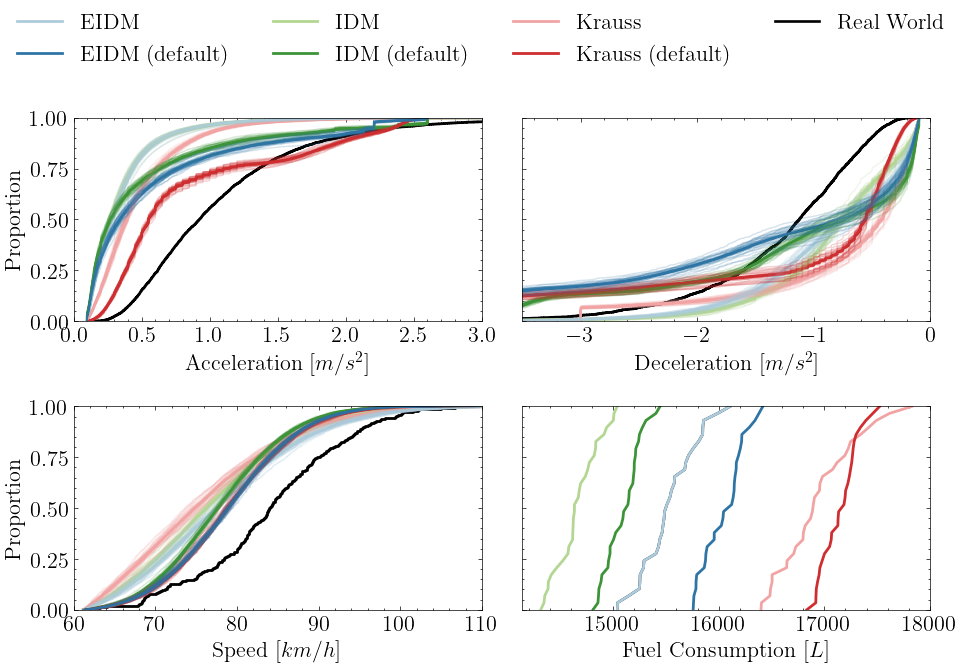

In [80]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend import _get_legend_handles_labels


color_map = {}
models = list(east_thru_df["carFollowingModel"].unique()) + ["Real World"]
# sort the models alphabetically
models.sort()
for i, model in enumerate(models):
    color_map[model] = colors[i]
    if model == "Real World":
        color_map[model] = "black"


# plotting acceleration with r2 > 0.9
create_ecdf(
    ax[0, 0],
    color_map,
    "accel",
    0.9,
    (0, 3),
    "slope",
    "Acceleration [$m/s^2$]",
    show_legend=False,
)
# # plotting deceleration with r2 > 0.9
create_ecdf(
    ax[0, 1], color_map, "decel", 0.9, (-3.5, 0), "slope", "Deceleration [$m/s^2$]"
)
# plot the speed with r2 > 0.9
create_ecdf(ax[1, 0], color_map, "cruise", 0.9, (60, 110), "speed", "Speed [$km/h$]")

# add in the fuel consumption histogram
sns.lineplot(
    x=np.sort(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values),
    y=np.linspace(
        0, 1, len(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values)
    ),
    ax=ax[1, 1],
    color=color_map["Real World"],
    alpha=1,
    linewidth=1.9,
    label="Real World",
)

for model in models:
    if model == "Real World":
        continue

    data = fuel_df[fuel_df["carFollowModel"] == model]["fuel"].values
    sns.lineplot(
        x=np.sort(data),
        y=np.linspace(0, 1, len(data)),
        ax=ax[1, 1],
        color=color_map[model],
        alpha=1,
        linewidth=2,
        label=model,
    )

ax[1, 1].set_xlabel("Fuel Consumption [$L$]")
h, l = ax[1, 1].get_legend_handles_labels()
# switch the first and last legend
h = h[1:] + [h[0]]
l = l[1:] + [l[0]]
fig.legend(h, l, loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1))
# remove the legend from 1,1
ax[1, 1].legend_.remove()


### Create a Latex table of the mean and median values for each model


In [ ]:
table = create_table(
    0.9,
)


(0.0, 3.5)

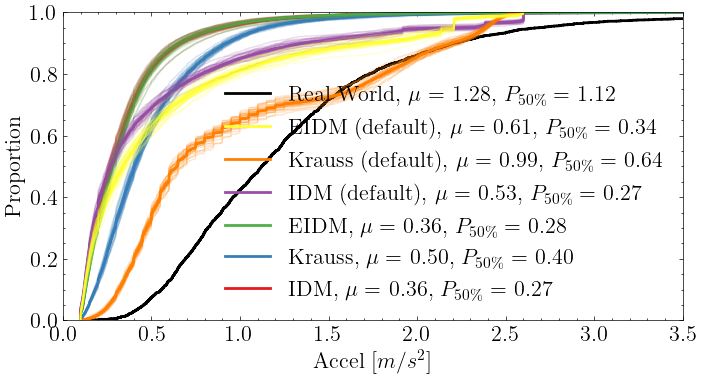

In [163]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["r2"] > 0.95)
    & (east_thru_df["type"] == "accel")
    & (east_thru_df["minimum_time"] > 0)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["r2"] > 0.95) & (rw_df["type"] == "accel") & (rw_df["minimum_time"] > 0)
].copy()
accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])

colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"


sns.ecdfplot(
    data=plot_df,
    x="slope",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "slope"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)

# set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['slope'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['slope'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Accel [$m/s^2$]")

# set the x and y axis limits
ax.set_xlim(0, 3.5)


KeyboardInterrupt: 

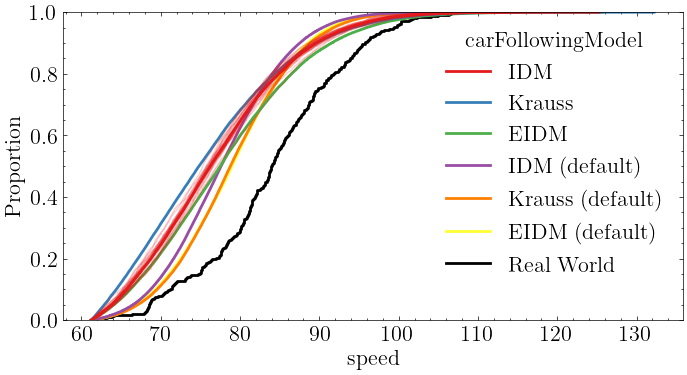

In [127]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["rmse"] < 0.05)
    & (east_thru_df["type"] == "cruise")
    & (east_thru_df["speed"] > 17)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["rmse"] < 0.05) & (rw_df["type"] == "cruise") & (rw_df["speed"] > 17)
].copy()

accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])
plot_df["speed"] = plot_df["speed"] * 3.6


colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"

sns.ecdfplot(
    data=plot_df,
    x="speed",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "speed"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# # sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# # remove the carFollowingModel title from the legend
# ax.legend_.set_title(None)

# # set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['speed'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['speed'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Speed [km/h]")


# set the x and y axis limits
ax.set_xlim(55, 120)


In [82]:
cruise_df["speed"].describe()


count    44.000000
mean     48.194663
std       7.517375
min      33.931664
25%      42.682669
50%      48.640121
75%      53.562594
max      62.983520
Name: speed, dtype: float64

In [68]:
slow_down_vehicles = rw_df.groupby("vehicle_id")["type"].apply(
    lambda x: any(x.str.contains("decel"))
)


In [69]:
slow_down_vehicles.sum() / slow_down_vehicles.shape[0]


0.8923151047940255

In [70]:
keep_vehicles = slow_down_vehicles[slow_down_vehicles == False].index


array([[<AxesSubplot: title={'center': 'speed'}>]], dtype=object)

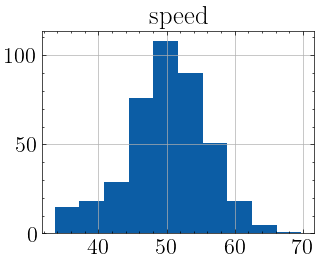

In [71]:
cruise_df.loc[cruise_df.vehicle_id.isin(keep_vehicles)].hist(
    column="speed",
)
